Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.7.3
IPython 7.9.0

torch 1.4.0


- Runs on CPU or GPU (if available)

# Vanilla Loss Gradient (wrt Inputs) Visualization 

## (Based on a VGG16 Convolutional Neural Network for Kaggle's Cats and Dogs Images)

Vizualization of the loss gradients with respect to the inputs (images) as a naive way to visualize CNN predictions. I.e.,

$$\nabla L(\mathbf{x})=  \left[\begin{array}{c}
\frac{\partial L}{\partial x_1} \\
\frac{\partial L}{\partial x_2} \\
\vdots
\end{array}\right]$$

Please note that this notebook is to be run after [./_cnn-basemodel__vgg16-cats-dogs.ipynb](_cnn-basemodel__vgg16-cats-dogs.ipynb), which trains the VGG16 model on thh cats and dogs dataset.

## Imports

In [2]:
import time
import os

import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn

from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [3]:
%matplotlib inline

## Settings

In [4]:
##########################
### SETTINGS
##########################

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
RANDOM_SEED = 1
BATCH_SIZE = 128

# Architecture
NUM_CLASSES = 2

# Image normalization parameters from _cnn-basemodel__vgg16-cats-dogs.ipynb
train_mean = [0.4875, 0.4544, 0.4164]
train_std = [0.2521, 0.2453, 0.2481]

## Cats vs Dogs Dataset

Please see [_cnn-basemodel__vgg16-cats-dogs.ipynb](_cnn-basemodel__vgg16-cats-dogs.ipynb) for instructions with regard to downloading this dataset and more details.

(331, 464, 3)


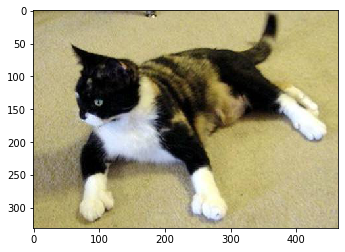

In [5]:
img = Image.open(os.path.join('dogs-vs-cats','train', 'cat.59.jpg'))
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

In [6]:
from datautils import CatsDogsDataset
from datautils import create_cats_and_dogs_dataloaders


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(64, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
}


train_loader, valid_loader, test_loader = create_cats_and_dogs_dataloaders(
    batch_size=BATCH_SIZE,
    data_transforms=data_transforms,
    train_path=os.path.join('dogs-vs-cats', 'train'), 
    valid_path=os.path.join('dogs-vs-cats', 'valid'), 
    test_path=os.path.join('dogs-vs-cats', 'test')
)

## Model

In [7]:
from vgg16 import VGG16

In [8]:
torch.manual_seed(RANDOM_SEED)
model = VGG16(num_classes=NUM_CLASSES)
model = model.to(DEVICE)

model.load_state_dict(torch.load('vgg16-cats-dogs.state_dict'))

<All keys matched successfully>

## Gradient Visualization

### Preprocessing Code

In [9]:
from datautils import UnNormalize


unorm = UnNormalize(mean=train_mean, std=train_std)


def preprocess_image(image_path, transform_func, unnormalize_func):
    
    pil_img = Image.open(image_path)
    img_tensor = transform_func(pil_img)
    unnormed_img_tensor = unnormalize_func(img_tensor)
    
    return pil_img, img_tensor, unnormed_img_tensor

In [10]:
def get_viz(image_tensor, label, model, device=DEVICE):
    """Computes loss gradient wrt inputs"""

    image_tensor = image_tensor.to(device)
    label = torch.tensor(label).to(device)
    # convert CHW tensor to NCHW tensor
    # note that N=1
    image_tensor = image_tensor.unsqueeze(0)

    ### Save input gradient
    image_tensor.requires_grad = True

    ### FORWARD AND BACK PROP
    logits, probas = model(image_tensor)
    cost = F.cross_entropy(logits, label)
    model.zero_grad()
    cost.backward()
    
    # get CHW tensor from NCHW tensor
    # note that N=1
    gradients = image_tensor.grad[0]
    return gradients

In [11]:
# Simple Hook class that records the input and output of a layer during forward/backward pass

class VanillaBackprop():
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def run(self, image_tensor, label):
        image_tensor = image_tensor.to(self.device)
        label = torch.tensor([label]).to(self.device)
        # convert CHW tensor to NCHW tensor
        # note that N=1
        image_tensor = image_tensor.unsqueeze(0)
        image_tensor.requires_grad = True

        ### FORWARD AND BACK PROP
        logits, probas = self.model(image_tensor)
        cost = F.cross_entropy(logits, label)
        self.model.zero_grad()
        cost.backward() # computes gradients via hook

        return image_tensor.grad[0]

In [12]:
vanillabackprop = VanillaBackprop(model, DEVICE)

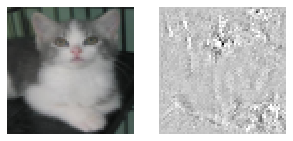

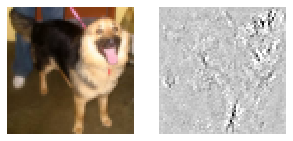

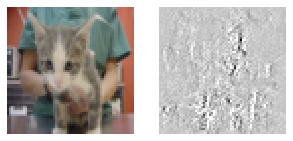

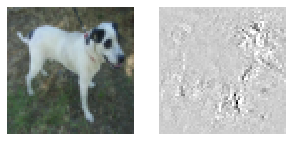

In [13]:
from datautils import convert_rgb_to_grayscale


model.eval()
        
    
for img_path, lab in zip(['cat.11252.jpg', 'dog.12018.jpg', 'cat.11267.jpg', 'dog.12077.jpg'], 
                         [0, 1, 0, 1]):
        
    pil_img, img_tensor, unnormed_img_tensor = preprocess_image(
        os.path.join('./dogs-vs-cats/test/', img_path), 
        data_transforms['valid'], 
        unorm
    )

    gradient = vanillabackprop.run(image_tensor=img_tensor, label=lab)
    
    # convert gradient to grayscale
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    gray_gradient = convert_rgb_to_grayscale(gradient.cpu().numpy())
    
    # visualize results
    fig, ax = plt.subplots(1, 2, figsize=(5, 10))

    # plot original
    ax[0].imshow(np.transpose(unnormed_img_tensor.cpu().numpy(), (1, 2, 0)))
    ax[0].axis('off')

    # plot gradient
    ax[1].imshow(np.transpose(gray_gradient, (1, 2, 0))[:, :, 0], cmap='gray')
    ax[1].axis('off')

    plt.show()